In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

In [2]:
IMAGE_SIZE = 60
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
RANDOM_IMAGES_NUMBER = 9999

In [3]:
def get_random_no_images(RANDOM_IMAGES_NUMBER = 4499, activate = False):
    if activate:
        all_images_0 = os.listdir(r'.\sliced_images_folder\all_images_jpg\no')
        random.shuffle(all_images_0)
        dir_path = r'.\sliced_images_folder\all_images_less_no\no'
        shutil.rmtree(dir_path)
        os.mkdir(dir_path)

        for i in range (RANDOM_IMAGES_NUMBER):
            original = fr'.\sliced_images_folder\all_images_jpg\no\{all_images_0[i]}'
            target = fr'.\sliced_images_folder\all_images_less_no\no\{all_images_0[i]}'
            shutil.copyfile(original, target)

In [4]:
get_random_no_images(RANDOM_IMAGES_NUMBER, activate = False)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'sliced_images_folder/all_images_less_no',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 14498 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [7]:
len(dataset)

454

In [8]:
def get_dataset_partitions_tf(ds, train_split = 0.6, val_split = 0.2, test_split = 0.2, shuffle_size = 10000, shuffle = True):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

272 90 92


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [15]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall) / (precision + recall + K.epsilon()))

In [17]:
model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(300, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(150, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(75, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'sigmoid')
])

model.build(input_shape = input_shape)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),    # losst minimalizálni -> f1 score nőhet, 1 - f1score
    #metrics = ['accuracy', f1_metric]# f1 score - precision / recall
    metrics = ['accuracy']          # precision, recallt bele írni, 0 vagy 1-eseket írja
    #metrics = ['acc', f1_m, precision_m, recall_m]
)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 60, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 300)       8400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 300)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 150)       405150    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 150)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 75)       

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
272/272 [==============================] - 11s 38ms/step - loss: 0.6239 - accuracy: 0.6861 - val_loss: 0.6222 - val_accuracy: 0.6861
Epoch 2/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6262 - accuracy: 0.6862 - val_loss: 0.6260 - val_accuracy: 0.6861
Epoch 3/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6256 - accuracy: 0.6861 - val_loss: 0.6242 - val_accuracy: 0.6861
Epoch 4/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6236 - accuracy: 0.6861 - val_loss: 0.6242 - val_accuracy: 0.6861
Epoch 5/20
272/272 [==============================] - 10s 37ms/step - loss: 0.4885 - accuracy: 0.7808 - val_loss: 0.3496 - val_accuracy: 0.8841
Epoch 6/20
272/272 [==============================] - 10s 37ms/step - loss: 0.3062 - accuracy: 0.8892 - val_loss: 0.2814 - val_accuracy: 0.9044
Epoch 7/20
272/272 [==============================] - 10s 37ms/step - loss: 0.2923 - accuracy: 0.8988 - val_loss: 0.2773 - val_accuracy:

In [24]:
scores = model.evaluate(test_ds)

272/272 [==============================] - 3s 12ms/step - loss: 0.2490 - accuracy: 0.9140


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


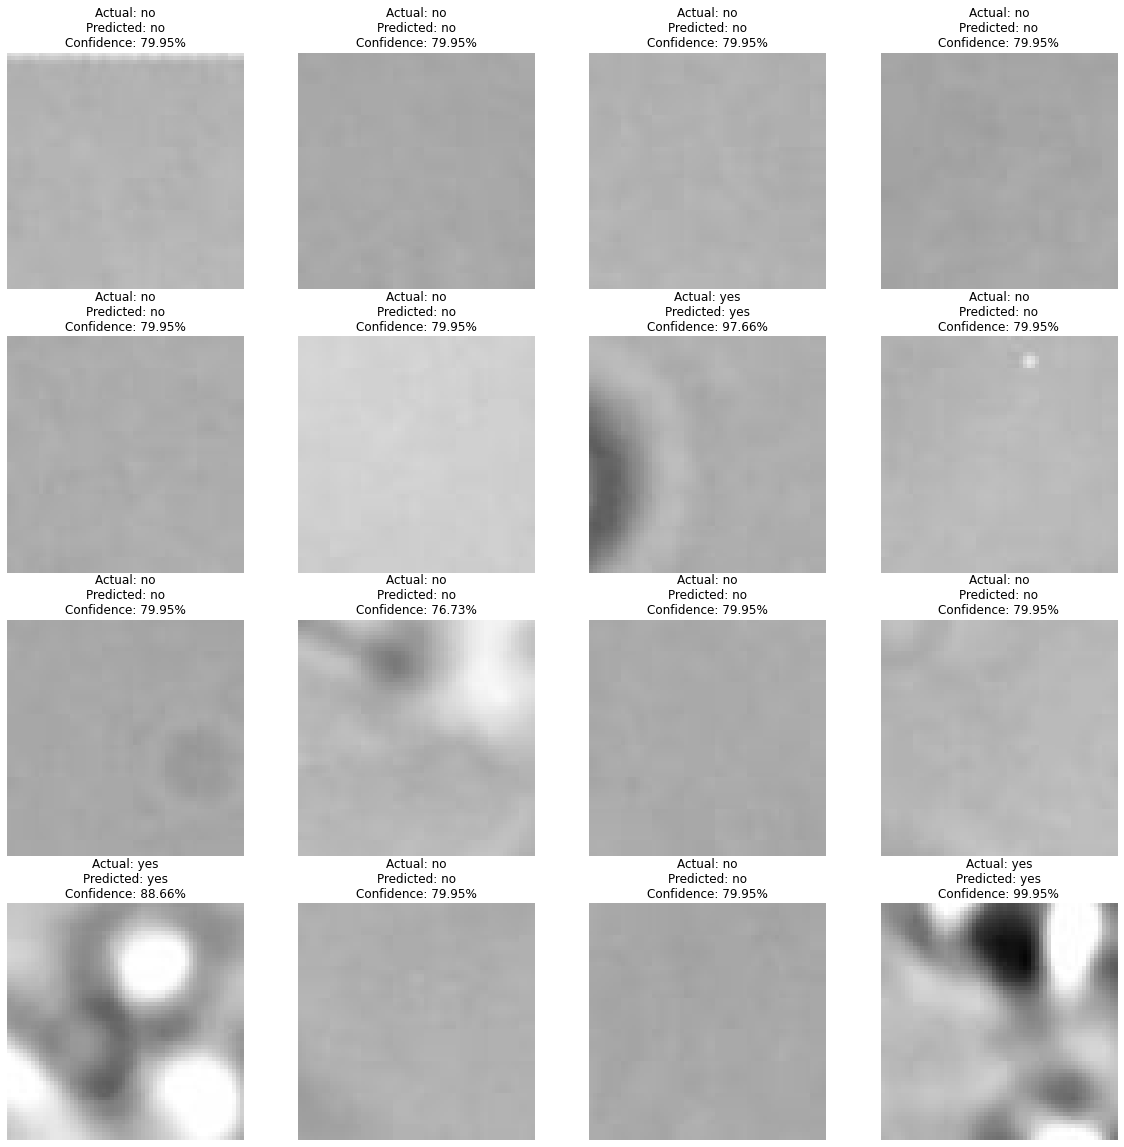

In [26]:
plt.figure(figsize = (20, 20))
for images, labels in test_ds.skip(2).take(1):
    for i in range (16):
        ax = plt.subplot(4,4,i+1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis('off')

In [27]:
model_version = 2
model.save(f'./models/{model_version}')

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

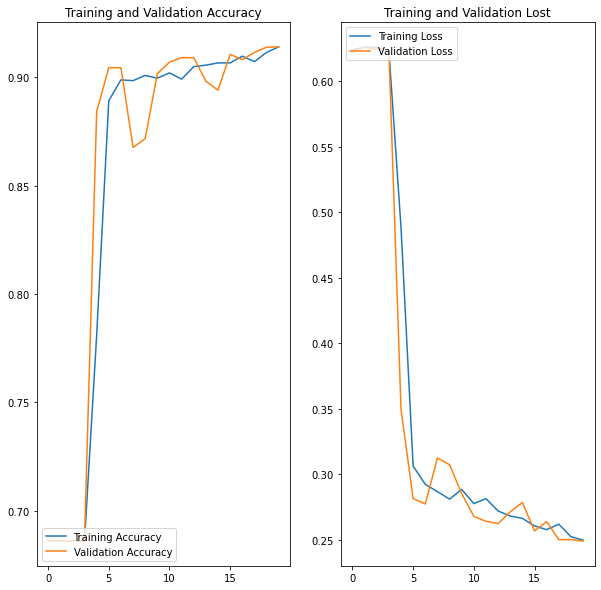

In [29]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Lost')
plt.show()

In [38]:
y_test = []
y_test_images = []
for images, labels in test_ds:
    for label in labels:
        y_test.append(label.numpy())
    for image in images:
        y_test_images.append(image)

In [41]:
y_predicted = model.predict(test_ds)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

272/272 [==============================] - 3s 11ms/step


In [48]:
y_predicted = model.predict(test_ds.take(1))
y_predicted_labels = [np.argmax(i) for i in y_predicted]

1/1 [==============================] - 0s 17ms/step


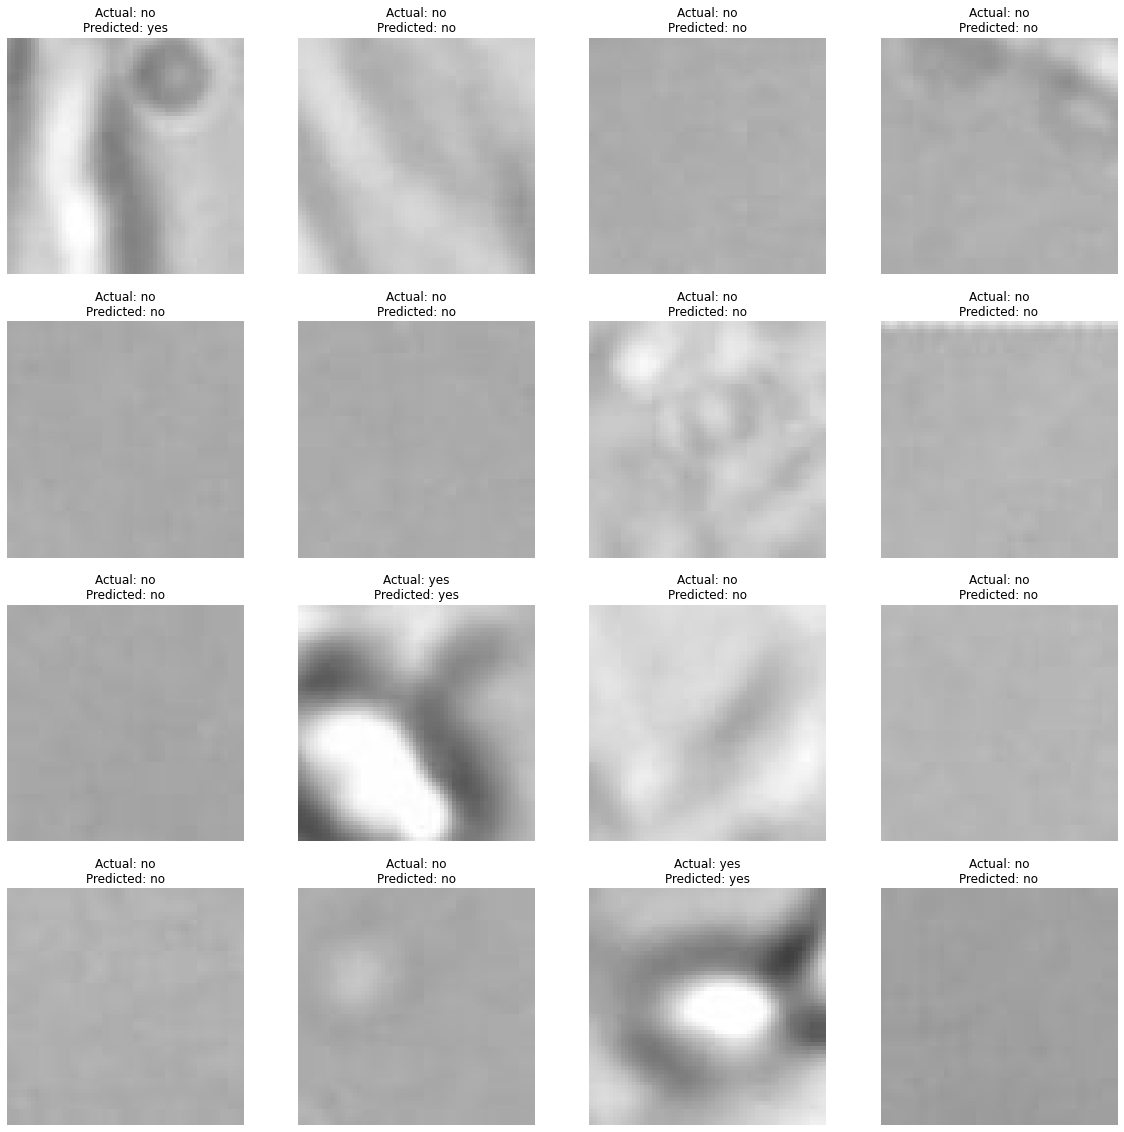

In [61]:
plt.figure(figsize = (20, 20))
for i in range (16):
    ax = plt.subplot(4, 4, i + 1)
    img = y_test_images[i]
    
    plt.imshow(img.numpy().astype('uint8'))
    
    img = img.numpy()
    img = np.reshape(img, [1, 60, 60, 3])
    plt.title(f'Actual: {class_names[y_test[i]]}\nPredicted: {class_names[np.argmax(model.predict(img, verbose = 0))]}')
    plt.axis('off')

In [62]:
# new predict for test_ds (8673 img)

y_predicted_label = []
for i in range (len(y_test)):
    # print(i) ->
    y_predicted_label.append(np.argmax(model.predict(np.reshape(y_test_images[i], [1, 60, 60, 3]), verbose = 0)))

In [63]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_label)

true_negative = cm.numpy()[0][0]
false_positive = cm.numpy()[1][0]
false_negative = cm.numpy()[0][1]
true_positive = cm.numpy()[1][1]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
f1_score = (2 * recall * precision) / (recall + precision)

# print('accuracy:', accuracy)
# print('recall:', recall)
# print('precision:', precision)
# print('f1_score:', f1_score)

Accuracy: 0.9139958496656675
Recall: 0.8884086444007858
Precision: 0.8303341902313625
F1_score: 0.8583902809415338


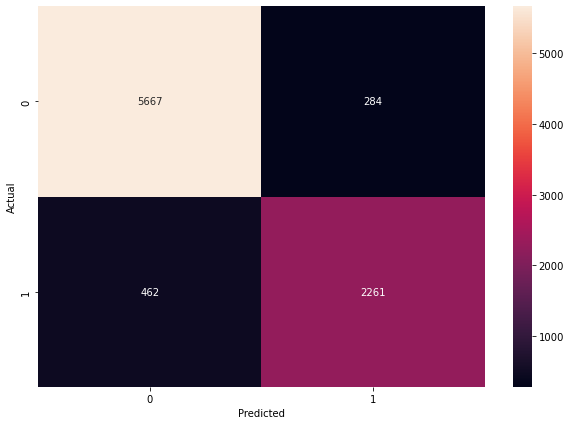

In [64]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1_score: {f1_score}')